# spacy

In [2]:
import pandas as pd

# Load kedua file
df_cerita = pd.read_csv("cerita_rakyat.csv")
df_annotated = pd.read_csv("even_semi_annotated.csv")

# Ambil story_id unik dari file annotated
valid_ids = df_annotated["story_id"].unique()

# Filter cerita_rakyat yang story_id-nya ada di valid_ids
filtered_df = df_cerita[df_cerita["story_id"].isin(valid_ids)]

# Simpan ke file baru
filtered_df.to_csv("cerita_rakyat_filtered.csv", index=False)

print(f"✅ Cerita rakyat difilter. Total baris: {len(filtered_df)}")


✅ Cerita rakyat difilter. Total baris: 23917


In [3]:
import pandas as pd

# Load file
df = pd.read_csv("even_semi_annotated.csv")

# Drop kolom 'number' dan 'TYPE1'
df = df.drop(columns=["number", "TYPE1"])

# Simpan ke file baru (atau bisa overwrite kalau mau)
df.to_csv("even_semi_annotated_cleaned.csv", index=False)

print("✅ Kolom 'number' dan 'TYPE1' berhasil dihapus.")


✅ Kolom 'number' dan 'TYPE1' berhasil dihapus.


In [6]:
import pandas as pd
import spacy

nlp = spacy.load("xx_ent_wiki_sm")
df = pd.read_csv("cerita_rakyat_filtered.csv")

grouped = df.groupby(["story_id", "sentence_id"])["word"].apply(lambda x: " ".join(x)).reset_index()

results = []

for _, row in grouped.iterrows():
    story_id = row["story_id"]
    sentence_id = row["sentence_id"]
    sentence = row["word"]

    doc = nlp(sentence)
    entities = list(set([ent.text for ent in doc.ents if ent.label_ == "PER"]))

    if entities:
        results.append({
            "story_id": story_id,
            "sentence_id": sentence_id,
            "characters": str(entities),
        })

output_df = pd.DataFrame(results)
output_df.to_csv("hasil_ner_spacy_per.csv", index=False)

print(f"✅ Selesai! Total kalimat dengan entitas PER (person): {len(output_df)}")


✅ Selesai! Total kalimat dengan entitas PER (person): 1361


📊 Precision : 0.0355
📊 Recall    : 0.0488
📊 Accuracy  : 0.0210
📊 F1-score  : 0.0411


C:\Users\rayssa\AppData\Local\Temp\ipykernel_3348\3907139687.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(extract_entity_mentions)


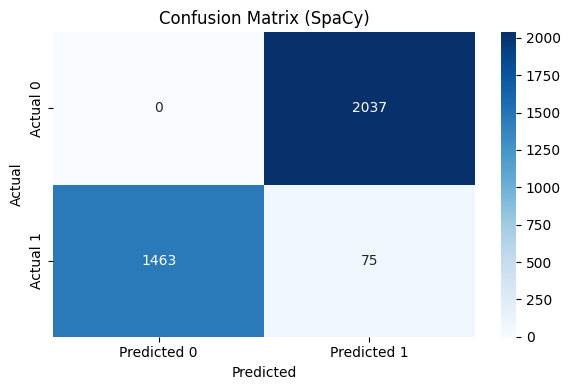

In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Load ground truth dan prediksi
gt_df = pd.read_csv("labelled.csv")
pred_df = pd.read_csv("hasil_ner_spacy_per.csv")
pred_df["characters"] = pred_df["characters"].apply(ast.literal_eval)

# === Step 1: Ekstrak entity span dari ground truth (B-PER/I-PER) ===
def extract_entity_mentions(group):
    entities = []
    current_entity = []
    for word, label in zip(group["word"], group["TYPE"]):
        if label == "B-PER":
            if current_entity:
                entities.append(" ".join(current_entity))
            current_entity = [word]
        elif label == "I-PER":
            current_entity.append(word)
        else:
            if current_entity:
                entities.append(" ".join(current_entity))
                current_entity = []
    if current_entity:
        entities.append(" ".join(current_entity))
    return list(set([e.lower() for e in entities]))  # lowercase

gt_entities_df = (
    gt_df.groupby(["story_id", "sentence_id"])
    .apply(extract_entity_mentions)
    .reset_index(name="true_entities")
)

# === Step 2: Gabungkan prediksi dan ground truth ===
merged = pd.merge(pred_df, gt_entities_df, on=["story_id", "sentence_id"], how="outer").fillna("[]")

# Ubah ke list
merged["true_entities"] = merged["true_entities"].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))
merged["characters"] = merged["characters"].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))

# === Step 3: Evaluasi per entitas ===
y_true, y_pred = [], []

for _, row in merged.iterrows():
    pred_entities = set([e.lower() for e in row["characters"]])
    true_entities = set([e.lower() for e in row["true_entities"]])
    all_entities = pred_entities.union(true_entities)

    for ent in all_entities:
        y_true.append(int(ent in true_entities))
        y_pred.append(int(ent in pred_entities))

# === Step 4: Hitung metrik ===
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

# Print metrik
print(f"📊 Precision : {precision:.4f}")
print(f"📊 Recall    : {recall:.4f}")
print(f"📊 Accuracy  : {accuracy:.4f}")
print(f"📊 F1-score  : {f1:.4f}")

# === Step 5: Simpan confusion matrix sebagai PNG ===
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (SpaCy)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig("confusion_matrix_spacy.png")  # <-- This saves it to your current directory
plt.show()


## fine tune

In [8]:
import pandas as pd
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

# Load spaCy untuk Bahasa Indonesia atau multilingual
nlp = spacy.blank("id")  # atau ganti "xx" kalau mau multilingual base

# Load file labelled.csv
df = pd.read_csv("labelled.csv")

# Gabungkan token per kalimat
grouped = df.groupby(["story_id", "sentence_id"])

# Buat DocBin
doc_bin = DocBin()

for (story_id, sentence_id), group in tqdm(grouped, desc="Processing sentences"):
    tokens = group["word"].tolist()
    labels = group["TYPE"].tolist()
    
    # Gabungkan token jadi 1 kalimat
    sentence = " ".join(tokens)
    doc = nlp.make_doc(sentence)

    # Cari span entity berdasarkan label IOB
    entities = []
    char_offset = 0
    current_entity = ""
    start = None

    for token, label in zip(tokens, labels):
        token_len = len(token)
        if start is not None:
            char_offset += 1  # tambahkan spasi sebelumnya
        if label == "B-PER":
            if start is not None:
                entities.append((start, char_offset - 1, "PER"))
            start = char_offset
        elif label == "I-PER":
            pass  # lanjut aja, kita akhiri nanti
        else:
            if start is not None:
                entities.append((start, char_offset - 1, "PER"))
                start = None
        char_offset += token_len

    if start is not None:
        entities.append((start, char_offset - 1, "PER"))

    # Tambahkan ke doc
    ents = []
    for start, end, label in entities:
        span = doc.char_span(start, end, label=label)
        if span:
            ents.append(span)
    doc.ents = ents
    doc_bin.add(doc)

# Simpan ke file
doc_bin.to_disk("train.spacy")  # bisa kamu salin jadi dev.spacy juga

print("✅ Selesai! File `train.spacy` berhasil dibuat.")


Processing sentences: 100%|██████████| 1157/1157 [00:00<00:00, 4434.69it/s]

✅ Selesai! File `train.spacy` berhasil dibuat.


🔎 spaCy Metrics
📌 Precision : 0.9947
📌 Recall    : 1.0000
📌 F1-score  : 0.9973

🧪 Custom Binary Entity Match Evaluation:
🎯 Precision : 0.9947
🎯 Recall    : 1.0000
🎯 Accuracy  : 0.9947
🎯 F1-score  : 0.9973


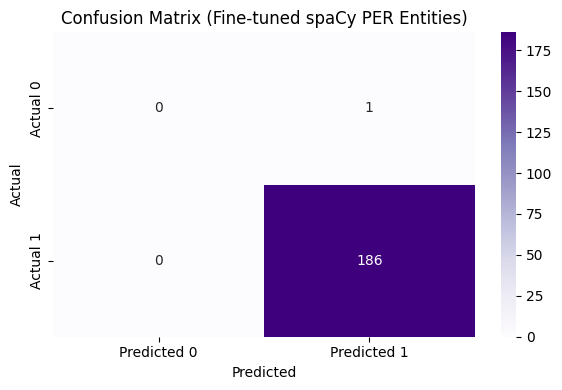

In [2]:
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
from spacy.scorer import Scorer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load fine-tuned model
nlp = spacy.load("output/model-best")

# Load evaluation data
doc_bin = DocBin().from_disk("train.spacy")  # or dev.spacy
docs = list(doc_bin.get_docs(nlp.vocab))

# Prepare examples
examples = [Example(predicted=nlp(doc.text), reference=doc) for doc in docs]

# Metric 1: spaCy native score (useful as reference)
scorer = Scorer()
scores = scorer.score(examples)

print(f"🔎 spaCy Metrics")
print(f"📌 Precision : {scores['ents_p']:.4f}")
print(f"📌 Recall    : {scores['ents_r']:.4f}")
print(f"📌 F1-score  : {scores['ents_f']:.4f}")

# Metric 2: Custom confusion matrix using binary entity match
y_true, y_pred = [], []

for ex in examples:
    pred_ents = set([ent.text.lower() for ent in ex.predicted.ents if ent.label_ == "PER"])
    true_ents = set([ent.text.lower() for ent in ex.reference.ents if ent.label_ == "PER"])
    all_ents = pred_ents.union(true_ents)
    
    for ent in all_ents:
        y_true.append(int(ent in true_ents))
        y_pred.append(int(ent in pred_ents))

# Calculate binary metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

# Print custom metrics
print("\n🧪 Custom Binary Entity Match Evaluation:")
print(f"🎯 Precision : {precision:.4f}")
print(f"🎯 Recall    : {recall:.4f}")
print(f"🎯 Accuracy  : {accuracy:.4f}")
print(f"🎯 F1-score  : {f1:.4f}")

# Save confusion matrix PNG
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix (Fine-tuned spaCy PER Entities)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig("confusion_matrix_finetuned_spacy.png")
plt.show()


In [2]:
import pandas as pd
import spacy

# Load best model
nlp = spacy.load("output/model-best")

# Load tokenized cerita rakyat
df = pd.read_csv("cerita_rakyat_filtered.csv")

# Gabungkan token per kalimat
grouped = df.groupby(["story_id", "sentence_id"])["word"].apply(lambda x: " ".join(x)).reset_index()

results = []

for _, row in grouped.iterrows():
    story_id = row["story_id"]
    sentence_id = row["sentence_id"]
    sentence = row["word"]

    # Inference NER
    doc = nlp(sentence)
    persons = list(set([ent.text for ent in doc.ents if ent.label_ == "PER"]))

    if persons:
        results.append({
            "story_id": story_id,
            "sentence_id": sentence_id,
            "characters": str(persons)
        })

# Simpan ke file
output_df = pd.DataFrame(results)
output_df.to_csv("hasil_ner_custom_model.csv", index=False)

print(f"✅ Labeling selesai. Total kalimat dengan entitas PER: {len(output_df)}")


✅ Labeling selesai. Total kalimat dengan entitas PER: 294


📊 Precision : 0.1014
📊 Recall    : 0.0195
📊 Accuracy  : 0.0166
📊 F1-score  : 0.0327


C:\Users\rayssa\AppData\Local\Temp\ipykernel_3348\1058451228.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(extract_entity_mentions)


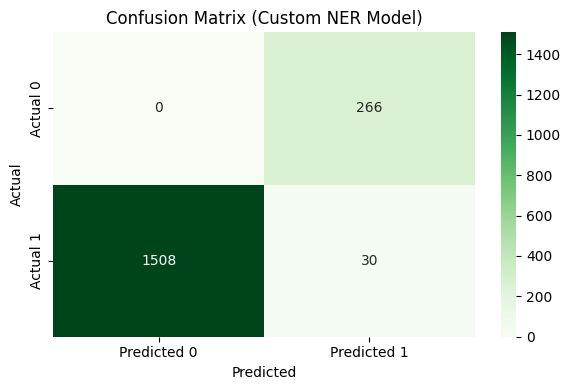

In [5]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Load hasil prediksi dan ground truth
pred_df = pd.read_csv("hasil_ner_custom_model.csv")
pred_df["characters"] = pred_df["characters"].apply(ast.literal_eval)

gt_df = pd.read_csv("labelled.csv")

# Step 1: Ekstrak entity PER dari ground truth
def extract_entity_mentions(group):
    entities = []
    current = []
    for word, label in zip(group["word"], group["TYPE"]):
        if label == "B-PER":
            if current:
                entities.append(" ".join(current))
            current = [word]
        elif label == "I-PER":
            current.append(word)
        else:
            if current:
                entities.append(" ".join(current))
                current = []
    if current:
        entities.append(" ".join(current))
    return list(set([e.lower() for e in entities]))

gt_entities_df = (
    gt_df.groupby(["story_id", "sentence_id"])
    .apply(extract_entity_mentions)
    .reset_index(name="true_entities")
)

# Step 2: Gabungkan prediksi dan ground truth
merged = pd.merge(pred_df, gt_entities_df, on=["story_id", "sentence_id"], how="outer").fillna("[]")
merged["characters"] = merged["characters"].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))
merged["true_entities"] = merged["true_entities"].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))

# Step 3: Entity-level evaluation
y_true, y_pred = [], []

for _, row in merged.iterrows():
    pred = set([x.lower() for x in row["characters"]])
    true = set([x.lower() for x in row["true_entities"]])
    all_entities = pred.union(true)
    for ent in all_entities:
        y_true.append(int(ent in true))
        y_pred.append(int(ent in pred))

# Step 4: Hitung metrik
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

# Print hasil
print(f"📊 Precision : {precision:.4f}")
print(f"📊 Recall    : {recall:.4f}")
print(f"📊 Accuracy  : {accuracy:.4f}")
print(f"📊 F1-score  : {f1:.4f}")

# Step 5: Simpan confusion matrix sebagai PNG
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix (Custom NER Model)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig("confusion_matrix_custom_model.png")
plt.show()
